In [1]:
import numpy as np
import librosa
import scipy
import matplotlib.pyplot as plt
import os
import time
from numpy import asarray
from numpy import save
from numpy import load

import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
DATASET = './DataSets/Emotions'

In [3]:
def ensure_sample_rate(waveform, original_sample_rate, desired_sample_rate=16000):
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return waveform, desired_sample_rate

In [4]:
labels = {
    'Angry': 0,
    'Happy': 1,
    'Sad': 2,
    'Fearful': 3,
    'Disgusted': 4,
    'Neutral': 5,
    'Suprised': 6
}

In [5]:
def remove_silence(signal, threshold=0.005):
    """
    Remove silence at the beginning and at the end of the signal
    """
    for i in range(len(signal)):
        if np.abs(signal[i]) > threshold:
            break
    for j in range(len(signal)-1, 0, -1):
        if np.abs(signal[j]) > threshold:
            break
    return signal[i:j]

In [6]:
lst = []
i = 0
start_time = time.time()
for subdir, dirs, files in os.walk(DATASET):
  print(subdir)
  print(i)
  for file in files:
    X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
    X = remove_silence(X)
    if len(X) == 0:
      continue

    mfcc_values = librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=4096, hop_length=256, n_mfcc=128).T
    mfccs_mean = np.mean(mfcc_values, axis=0)
    mfccs_std = np.std(mfcc_values, axis=0)
    mfccs = np.concatenate((mfccs_mean, mfccs_std), axis=0)
    lst.append((mfccs, i))

  if files:
    i = i + 1
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

./DataSets/Emotions
0
./DataSets/Emotions\Angry
0
--- Data loaded. Loading time: 139.2918210029602 seconds ---
./DataSets/Emotions\Disgusted
1
--- Data loaded. Loading time: 228.04324316978455 seconds ---
./DataSets/Emotions\Fearful
2
--- Data loaded. Loading time: 344.36590695381165 seconds ---
./DataSets/Emotions\Happy
3
--- Data loaded. Loading time: 467.93849778175354 seconds ---
./DataSets/Emotions\Neutral
4
--- Data loaded. Loading time: 557.4954051971436 seconds ---
./DataSets/Emotions\Sad
5
--- Data loaded. Loading time: 689.6417973041534 seconds ---
./DataSets/Emotions\Suprised
6
--- Data loaded. Loading time: 734.5275988578796 seconds ---


In [7]:
save('./DataSets/data.npy', asarray(lst), allow_pickle=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9872\3492346563.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  save('./DataSets/data.npy', asarray(lst), allow_pickle=True)


In [8]:
data = load('./DataSets/data.npy', allow_pickle=True)

# Clasificador

In [9]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

x_trainn = np.expand_dims(X_train, axis=2) 
x_testnn = np.expand_dims(X_test, axis=2)
x_valnn = np.expand_dims(X_val, axis=2)

In [10]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(256, 1)),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(10, activation='softmax')
])

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    x_trainn, 
    y_train, 
    batch_size=64, 
    epochs=1400, 
    validation_data=(x_valnn, y_val)
)

Epoch 1/1400
120/120 [==============================] - 1s 7ms/step - loss: 53.4294 - accuracy: 0.1205 - val_loss: 41.9881 - val_accuracy: 0.1555
Epoch 2/1400
120/120 [==============================] - 1s 5ms/step - loss: 45.6099 - accuracy: 0.1355 - val_loss: 38.8920 - val_accuracy: 0.2680
Epoch 3/1400
120/120 [==============================] - 1s 5ms/step - loss: 42.0222 - accuracy: 0.1454 - val_loss: 37.0345 - val_accuracy: 0.2410
Epoch 4/1400
120/120 [==============================] - 1s 5ms/step - loss: 39.6103 - accuracy: 0.1611 - val_loss: 36.1227 - val_accuracy: 0.2418
Epoch 5/1400
120/120 [==============================] - 1s 5ms/step - loss: 38.0531 - accuracy: 0.1655 - val_loss: 35.2029 - val_accuracy: 0.2215
Epoch 6/1400
120/120 [==============================] - 1s 5ms/step - loss: 36.6416 - accuracy: 0.1754 - val_loss: 34.1687 - val_accuracy: 0.2148
Epoch 7/1400
120/120 [==============================] - 1s 5ms/step - loss: 35.4199 - accuracy: 0.1763 - val_loss: 33.1469 -

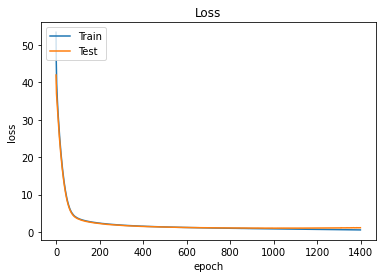

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

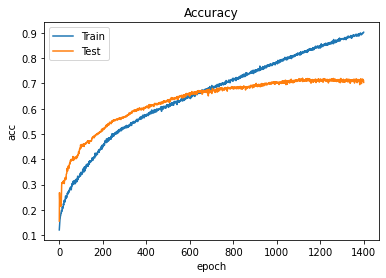

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
predictions = np.argmax(model.predict(x_testnn),axis=1)
y_test = y_test.astype(int)
report = classification_report(y_test, predictions)
print(report)

80/80 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       456
           1       0.67      0.62      0.64       372
           2       0.71      0.65      0.68       414
           3       0.68      0.70      0.69       410
           4       0.75      0.76      0.75       383
           5       0.70      0.69      0.70       403
           6       0.88      0.93      0.90       121

    accuracy                           0.73      2559
   macro avg       0.74      0.75      0.74      2559
weighted avg       0.73      0.73      0.73      2559



## Matriz de confusion

In [16]:
matrix = confusion_matrix(y_test, predictions)

<AxesSubplot:>

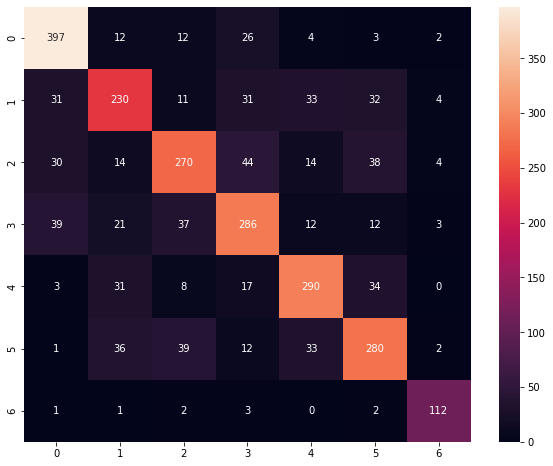

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d")